---

### Graded Challenge 7

- Nama              : Muhammad Afza Nur Hakim
- Batch             : HCK-034
---

# Problem Statement and Dataset Description

### Problem Statement

Proses pemantauan dan pencatatan keanekaragaman hayati laut (marine biodiversity) masih menghadapi tantangan besar karena volume data gambar atau video bawah air yang sangat besar dan kondisi lingkungan yang kompleks.

Proses identifikasi dan klasifikasi spesies biota laut (seperti membedakan biota seperti lumba-lumba, ikan, lobster, gurita, dan kuda laut) saat ini masih sering bergantung pada:

- Analisis manual oleh ahli biologi laut dari rekaman footage bawah air.

- Metode survei tradisional yang memakan waktu dan mahal.

- Proses pengolahan data yang lambat yang bisa saja menghambat respons cepat terhadap perubahan ekologis.

Kesalahan atau keterlambatan dalam klasifikasi jenis biota laut dapat menyebabkan:

- Ketidakakuratan dalam estimasi populasi dan tren ekologis.

- Pengambilan keputusan konservasi yang kurang tepat atau terlambat.

- Pemborosan waktu dan sumber daya peneliti dalam menyaring data mentah.

Oleh karena itu, diperlukan sebuah pendekatan otomatis berbasis Computer Vision  yang mampu mengklasifikasikan lima jenis biota laut tersebut secara akurat menggunakan gambar yang diambil dari kamera bawah air baik dari Remotely Operated Vehicle (ROV) ataupun stasiun pemantauan

### Objective

Project ini dibuat untuk mengembangkan model Computer Vision (CNN) yang mampu mengklasifikan lima jenis biota laut (lumba-lumba, ikan, lobster, gurita, dan kuda laut) secara akurat menggunakan gambar dari kamera bawah air. Sehingga project ini dapat meningkatkan keandalan marine biodiversity monitoring, memberikan insight ekologis yang cepat, serta mendukung upaya konservasi laut global.

### Sumber Dataset

- Nama Dataset : Marine Image Dataset for Classification
- Asal Dataset : Diambil dari Kaggle (https://www.kaggle.com/datasets/ananya12verma/marine-image-dataset-for-classification)
- Tentang Dataset : Dataset ini berisi 5 class dari binatang laut, yang terdiri dari: Lumba-lumba, Ikan, Lobster, Gurita, dan Kuda Laut. Training Data berisi 1.242 gambar, Validation Data berisi 250 gambar, dan Test Data berisi 100 gambar. Gambar yang ada memiliki format RGB

# Import Libraries

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
from tensorflow.keras.optimizers import Adam

# Data Loading

In [2]:
print("Mounting Google Drive...")
drive.mount('/content/drive') # mount dari google drive

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# menentukan resolusi gambar dan path directory
IMAGE_SIZE = (299, 299)
BASE_DRIVE_DIR = '/content/drive/MyDrive/marine-animals-dataset'

# menentukan direktori untuk masing-masing subset
TRAIN_DIR = os.path.join(BASE_DRIVE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DRIVE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DRIVE_DIR, 'test')

Melakukan data loading dengan mounting dari Google Drive dan menentukan direktori untuk setiap subset

Kelas yang ditemukan: ['Dolphin', 'Fish', 'Lobster', 'Octopus', 'Sea Horse']


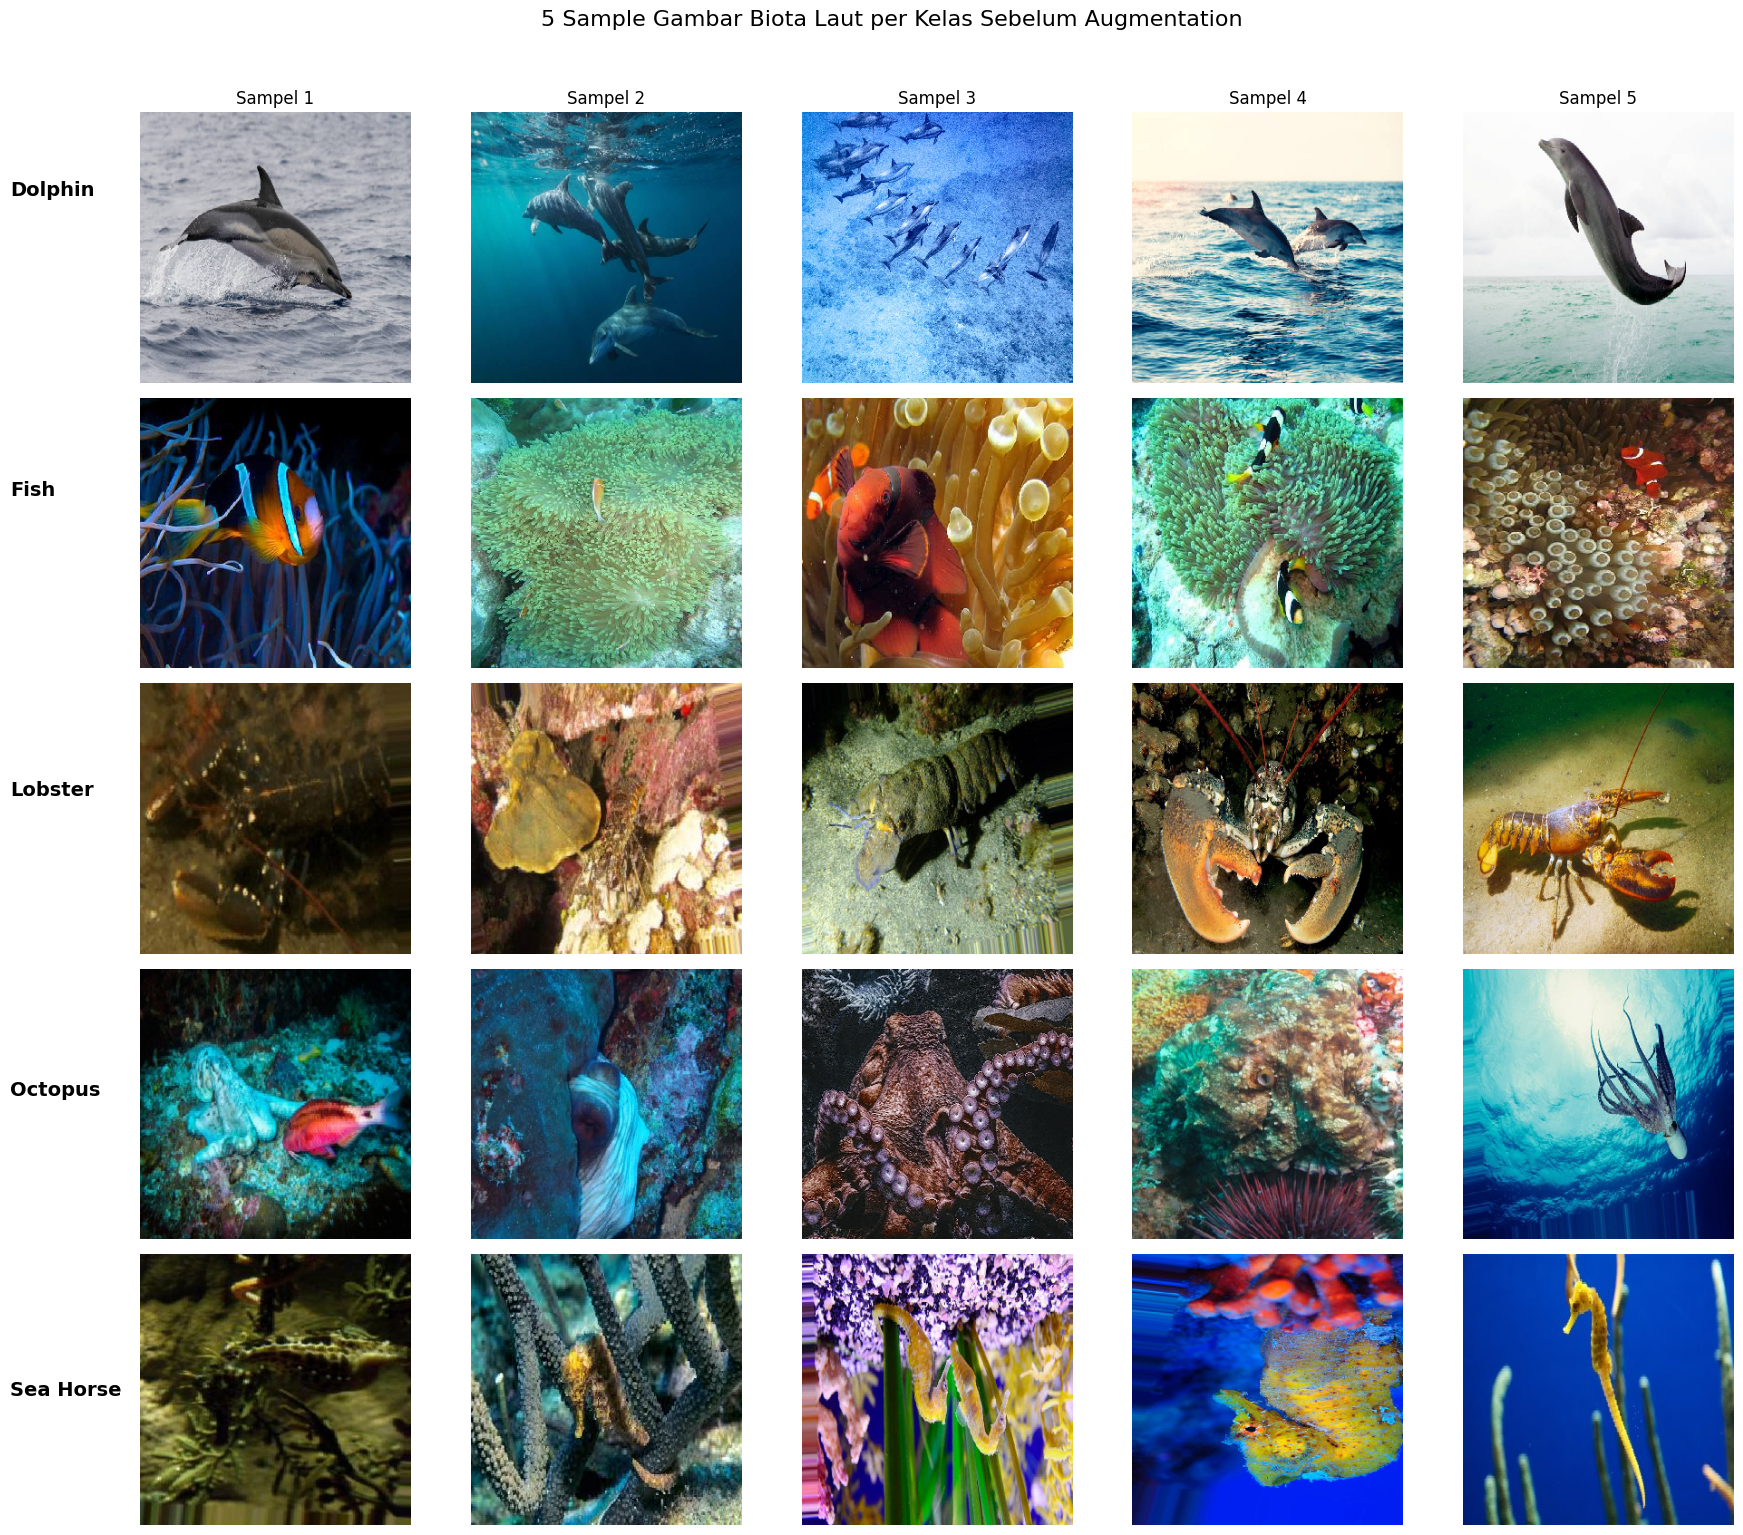


Visualisasi 5 sample per kelas telah berhasil dibuat.


In [4]:
# menentukan jumlah sample per kelas
SAMPLES_PER_CLASS = 5
NUM_CLASSES = 5
TOTAL_IMAGES_TO_SHOW = SAMPLES_PER_CLASS * NUM_CLASSES

# mendapatkan daftar nama kelas (sub-folder)
CLASS_NAMES = sorted(os.listdir(TRAIN_DIR))
print(f"Kelas yang ditemukan: {CLASS_NAMES}")

# Buat figure dengan 5 baris (untuk 5 kelas) dan 5 kolom (untuk 5 sampel)
fig, axes = plt.subplots(NUM_CLASSES, SAMPLES_PER_CLASS, figsize=(18, 15))
fig.suptitle(f"5 Sample Gambar Biota Laut per Kelas Sebelum Augmentation",
             fontsize=16, y=1.02)

# menentukan posisi teks Y-axis
y_position_step = 1 / (NUM_CLASSES * 2)

# iterasi melalui setiap kelas
for i, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)

    # ambil daftar semua file di folder kelas tersebut
    all_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # ambil selalu 5 file pertama
    sample_files = all_files[:SAMPLES_PER_CLASS]

    # menentukan posisi Y untuk menempatkan nama kelas di sebelah kiri baris
    y_position = 1 - ((i * 2 + 1) * y_position_step)

    # menambahkan nama kelas menggunakan fig.text()
    fig.text(0.01,                 # Posisi X di paling kiri (1%)
             y_position,           # Posisi Y yang sudah ditentukan
             class_name,
             fontsize=14,
             fontweight='bold',
             ha='left',            # Align horizontal ke kiri
             va='center')          # Align vertikal ke tengah


    # Iterasi melalui 5 sampel
    for j, file_name in enumerate(sample_files):
        file_path = os.path.join(class_path, file_name)

        # load image menggunakan Keras
        img = load_img(file_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img)

            # menampilkan gambar di subplot yang sesuai
        axes[i, j].imshow(img_array.astype("uint8"))
        axes[i, j].axis("off")

            # menambahkan label kolom di baris pertama
        if i == 0:
                axes[i, j].set_title(f"Sampel {j+1}", fontsize=12)

            # menghapus semua tick dan label default
        axes[i, j].set_yticks([])
        axes[i, j].set_xticks([])

plt.tight_layout(rect=[0.05, 0, 1, 1]) # menyesuaikan layout agar ada ruang untuk fig.text di kiri
plt.show()

print("\nVisualisasi 5 sample per kelas telah berhasil dibuat.")

Sample gambar dari setiap class yang akan digunakan sebagai Train Set berhasil diload

In [5]:
# Daftar kelas yang ada dalam dataset
labels = ['Dolphin', 'Fish', 'Lobster', 'Octopus', 'Sea Horse']
base_path = TRAIN_DIR

print("--- Hasil Cek Ukuran dan Format Gambar Sampel ---")

# Iterasi melalui setiap label
for lbl in labels:
    class_path = os.path.join(base_path, lbl)

    # Memastikan folder kelas ada
    if os.path.isdir(class_path):
        # Mengambil daftar file dan hanya mengambil file gambar
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Cek 1 gambar pertama per class
        if img_files:
            # Mengambil nama file pertama
            img_filename = img_files[0]
            img_path = os.path.join(class_path, img_filename)
                # Membuka gambar menggunakan PIL
            img = Image.open(img_path)
                # Mencetak ukuran dan format
            print(f"Kelas '{lbl}': Ukuran Gambar: {img.size} (Format: {img.format})")

--- Hasil Cek Ukuran dan Format Gambar Sampel ---
Kelas 'Dolphin': Ukuran Gambar: (612, 408) (Format: JPEG)
Kelas 'Fish': Ukuran Gambar: (500, 334) (Format: JPEG)
Kelas 'Lobster': Ukuran Gambar: (300, 225) (Format: JPEG)
Kelas 'Octopus': Ukuran Gambar: (300, 200) (Format: JPEG)
Kelas 'Sea Horse': Ukuran Gambar: (225, 300) (Format: JPEG)


Ukuran gambar tiap class tidak uniform, sehingga nanti akan dilakukan resizing ke ukuran 299x299, resizing ini dilakukan untuk mengoptimalkan training model

In [6]:
# Iterasi melalui setiap label
for lbl in labels:
    class_path = os.path.join(base_path, lbl)

    # Memastikan folder kelas
    if os.path.isdir(class_path):
        # Mengambil daftar file gambar
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Cek 1 gambar pertama per class
        if img_files:
            img_filename = img_files[0]
            img_path = os.path.join(class_path, img_filename)

                # Membuka gambar
            img = Image.open(img_path)
                # cek color channel
            print(f"Class '{lbl}': Color Channel: {img.mode}")

Class 'Dolphin': Color Channel: RGB
Class 'Fish': Color Channel: RGB
Class 'Lobster': Color Channel: RGB
Class 'Octopus': Color Channel: RGB
Class 'Sea Horse': Color Channel: RGB


Color channel untuk semua gambar setiap kelas adalah RGB, hal ini penting untuk proses pada model

In [7]:
def get_class_counts_from_filesystem(directory, class_names):
    """Menghitung jumlah file (gambar) di setiap subdirektori (kelas) dari disk."""
    counts = {}
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            num_files = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            counts[class_name] = num_files
        else:
            counts[class_name] = 0
    return counts

train_counts = get_class_counts_from_filesystem(TRAIN_DIR, CLASS_NAMES)
val_counts = get_class_counts_from_filesystem(VALID_DIR, CLASS_NAMES)
test_counts = get_class_counts_from_filesystem(TEST_DIR, CLASS_NAMES)

print(f"\n--- Distribusi Kelas Training Set ---\nTotal Sample Dihitung: {sum(train_counts.values())}")
print(train_counts)

print(f"\n--- Distribusi Kelas Validation Set ---\nTotal Sample Dihitung: {sum(val_counts.values())}")
print(val_counts)

print(f"\n--- Distribusi Kelas Test Set ---\nTotal Sample Dihitung: {sum(test_counts.values())}")
print(test_counts)

data = {
    'Training Set': train_counts,
    'Validation Set': val_counts,
    'Test Set': test_counts
}

df_counts = pd.DataFrame(data).T
df_counts['Total'] = df_counts.sum(axis=1)

print("\n--- Ringkasan Distribusi Kelas ---\n")
print(df_counts)


--- Distribusi Kelas Training Set ---
Total Sample Dihitung: 1245
{'Dolphin': 198, 'Fish': 290, 'Lobster': 252, 'Octopus': 253, 'Sea Horse': 252}

--- Distribusi Kelas Validation Set ---
Total Sample Dihitung: 250
{'Dolphin': 50, 'Fish': 50, 'Lobster': 50, 'Octopus': 50, 'Sea Horse': 50}

--- Distribusi Kelas Test Set ---
Total Sample Dihitung: 100
{'Dolphin': 20, 'Fish': 20, 'Lobster': 20, 'Octopus': 20, 'Sea Horse': 20}

--- Ringkasan Distribusi Kelas ---

                Dolphin  Fish  Lobster  Octopus  Sea Horse  Total
Training Set        198   290      252      253        252   1245
Validation Set       50    50       50       50         50    250
Test Set             20    20       20       20         20    100


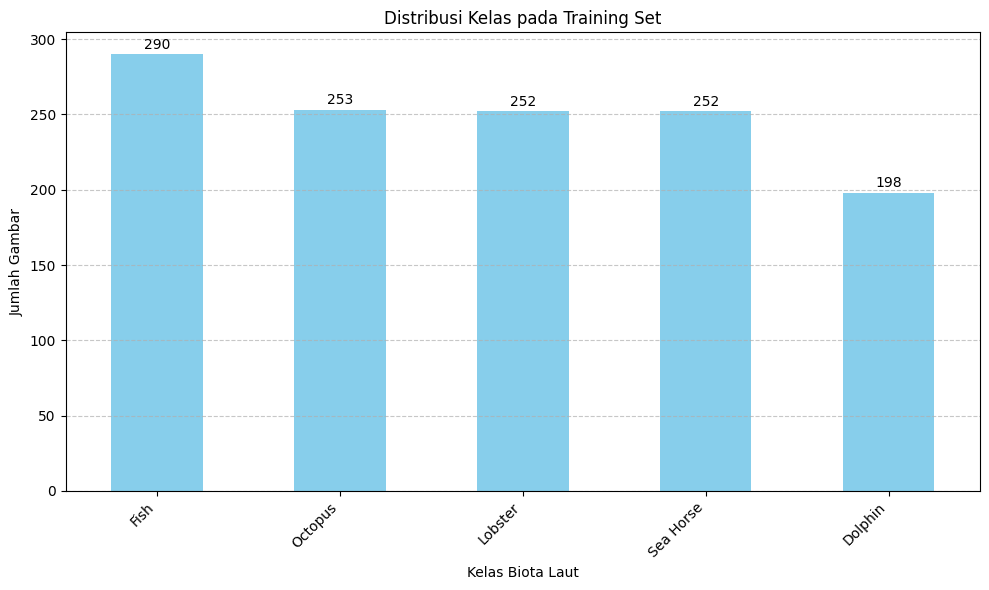


Visualisasi distribusi kelas Training Set berhasil dibuat


In [8]:
# Ambil data untuk visualisasi Training Set
df_train = pd.Series(train_counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
df_train.plot(kind='bar', color='skyblue')

# Menambahkan label dan judul
plt.title('Distribusi Kelas pada Training Set')
plt.xlabel('Kelas Biota Laut')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for index, value in enumerate(df_train):
    plt.text(index, value + 3.7, str(value), ha='center')

plt.tight_layout()
plt.show()

print("\nVisualisasi distribusi kelas Training Set berhasil dibuat")

Dataset training ini dapat dikategorikan sebagai balance, walaupun kelas terbanyak (Fish) memiliki sample sejumlah 290 dan kelas tersedikit (Dolphin) memiliki sample sejumlah 198, sehingga memilki selisih sebanyak 92 sample

Rasio kelas terbanyak dengan kelas tersedikit adalah 290/198 atau sekitar 1,45:1, rasio di bawah 2:1 umumnya masih dapat dianggap dapat digunakan tanpa perlu dilakukan data balancing seperti oversampling atau undersampling

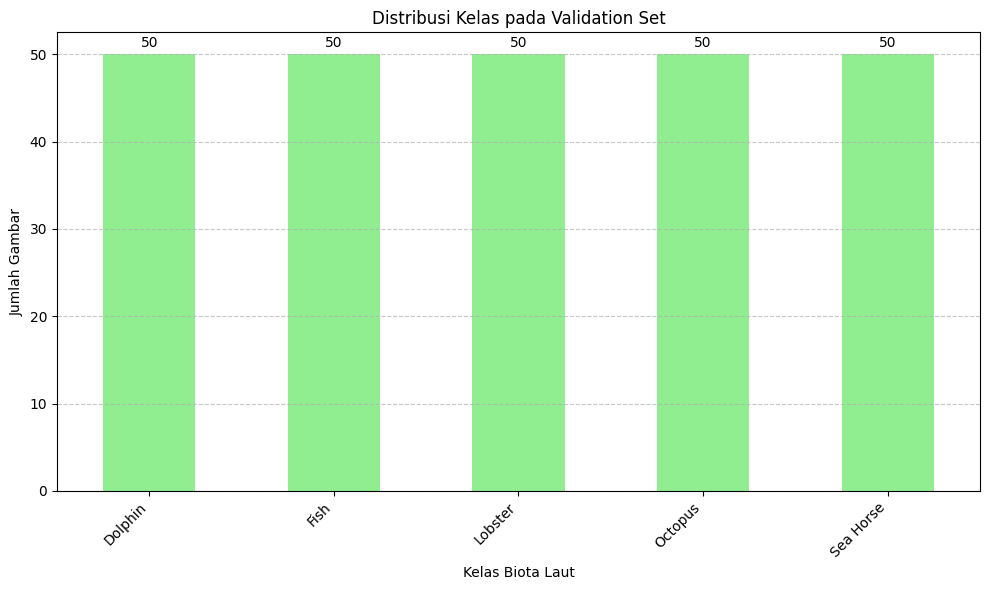


Visualisasi distribusi kelas Validation Set telah dibuat


In [9]:
# Ambil data untuk visualisasi Validation Set
df_val = pd.Series(val_counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
df_val.plot(kind='bar', color='lightgreen') # Menggunakan warna berbeda

# Menambahkan label dan judul
plt.title('Distribusi Kelas pada Validation Set')
plt.xlabel('Kelas Biota Laut')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for index, value in enumerate(df_val):
    plt.text(index, value + 0.8, str(value), ha='center')

plt.tight_layout()
plt.show()

print("\nVisualisasi distribusi kelas Validation Set telah dibuat")

Validation set memiliki 50 sample untuk setiap class sehingga sudah perfectly balanced

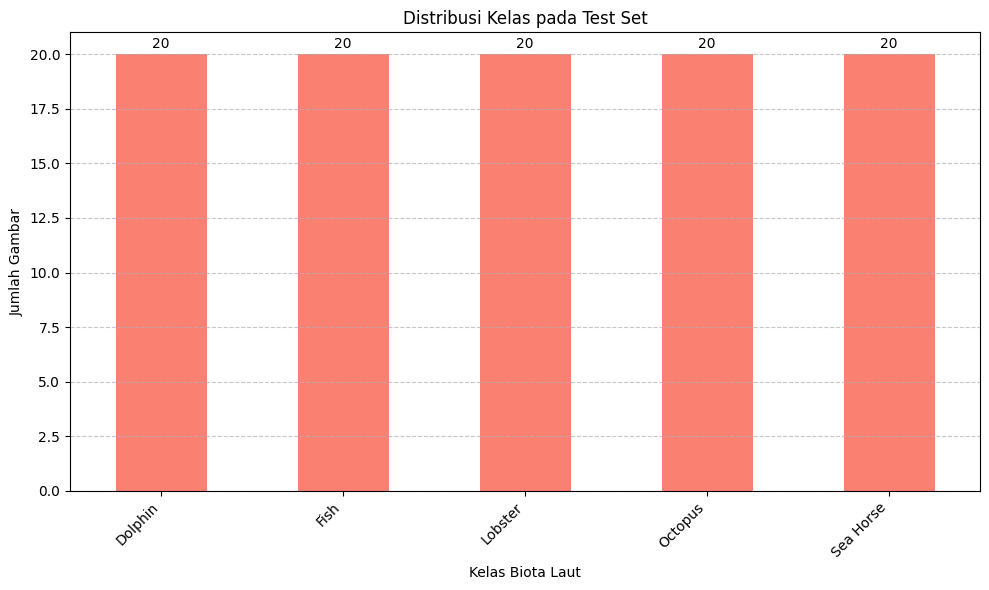


Visualisasi distribusi kelas Test Set telah dibuat.


In [10]:
# Ambil data untuk visualisasi Test Set
df_test = pd.Series(test_counts).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
df_test.plot(kind='bar', color='salmon') # Menggunakan warna berbeda

# Menambahkan label dan judul
plt.title('Distribusi Kelas pada Test Set')
plt.xlabel('Kelas Biota Laut')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan nilai di atas bar
for index, value in enumerate(df_test):
    plt.text(index, value + 0.3, str(value), ha='center')

plt.tight_layout()
plt.show()

print("\nVisualisasi distribusi kelas Test Set telah dibuat.")

Test set memiliki 20 sample untuk setiap class sehingga sudah perfectly balanced

Data Validation dan Test sudah sangat seimbang (50:50:50:50:50 dan 20:20:20:20:20), kemudian data Training Set termasuk seimbang (rasio 1,45:1) sehingga Accuracy dapat digunakan sebagai metric utama. Namun, dalam bagian Model Evaluation tetap akan ditampilkan metric Classification Report yang menampilkan Precision, Recall, dan F1-Score per kelas untuk memberikan analisis kinerja yang lebih komprehensif

# Exploratory Data Analysis

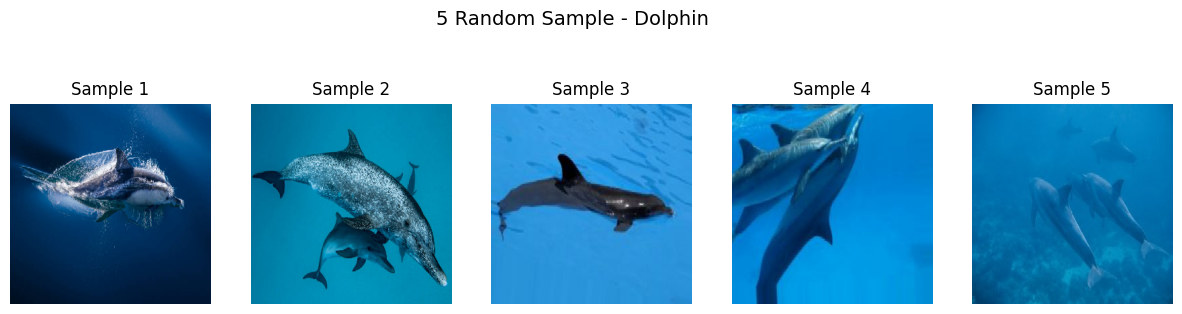

In [11]:
RANDOM_SEED = 18 # menggunakan random seed agar gambar selalu sama
random.seed(RANDOM_SEED)

# ambil kelas pertama
first_class = CLASS_NAMES[0]
class_path = os.path.join(TRAIN_DIR, first_class)

# ambil semua file gambar
all_files = [
    f for f in os.listdir(class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# urutkan agar konsisten
all_files = sorted(all_files)

# ambil 5 gambar random tapi selalu sama
sample_files = random.sample(all_files, SAMPLES_PER_CLASS)

fig, axes = plt.subplots(1, SAMPLES_PER_CLASS, figsize=(15, 4))
fig.suptitle(f"5 Random Sample - {first_class}", fontsize=14)

for j, file_name in enumerate(sample_files):
    file_path = os.path.join(class_path, file_name)
    img = load_img(file_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)

    axes[j].imshow(img_array.astype("uint8"))
    axes[j].axis("off")
    axes[j].set_title(f"Sample {j+1}")

plt.show()

Kelas pertama adalah lumba-lumba yang memiliki ciri-ciri sebagai berikut:
- Semua sampel diambil di bawah air dengan latar belakang biru cerah atau gelap menunjukkan laut dalam
- Memiliki sirip, ekor, dan moncong yang cukup panjang dengan warna dominan abu-abu atau biru kehitaman
- Lumba-lumba bisa ditemukan secara individu maupun berkelompok

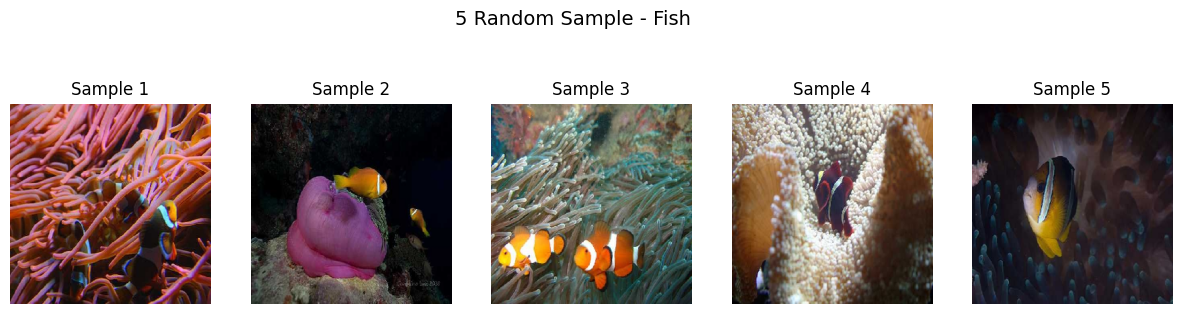

In [12]:
# ambil kelas kedua
second_class = CLASS_NAMES[1]
class_path = os.path.join(TRAIN_DIR, second_class)


all_files = [
    f for f in os.listdir(class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

all_files = sorted(all_files)

sample_files = random.sample(all_files, SAMPLES_PER_CLASS)

fig, axes = plt.subplots(1, SAMPLES_PER_CLASS, figsize=(15, 4))
fig.suptitle(f"5 Random Sample - {second_class}", fontsize=14)

for j, file_name in enumerate(sample_files):
    file_path = os.path.join(class_path, file_name)
    img = load_img(file_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)

    axes[j].imshow(img_array.astype("uint8"))
    axes[j].axis("off")
    axes[j].set_title(f"Sample {j+1}")

plt.show()

Kelas kedua adalah ikan yang secara spesifik menunjukkan spesies Clownfish (Nemo) yang memiliki ciri-ciri sebagai berikut:
- Ikan ini memilki warna oranye dengan strip putih
- Sampel menunjukkan ikan berada di antara karang atau tentakel anemon laut yang merupakan habitat utamanya

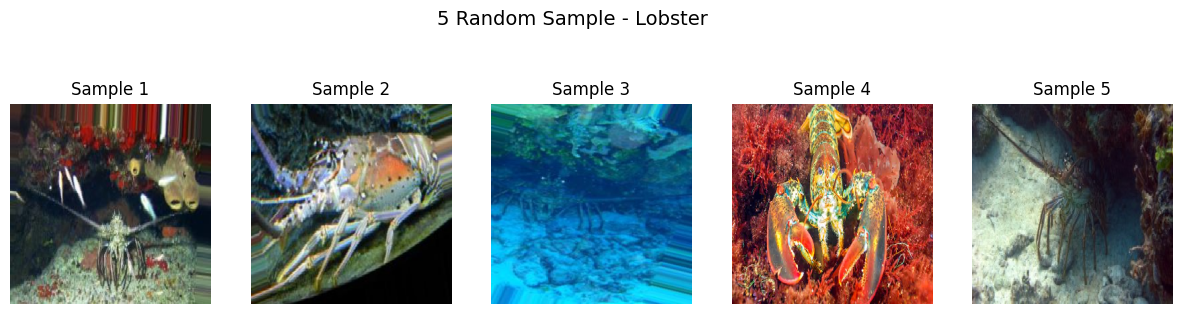

In [13]:
# ambil kelas ketiga
third_class = CLASS_NAMES[2]
class_path = os.path.join(TRAIN_DIR, third_class)

all_files = [
    f for f in os.listdir(class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

all_files = sorted(all_files)

sample_files = random.sample(all_files, SAMPLES_PER_CLASS)

fig, axes = plt.subplots(1, SAMPLES_PER_CLASS, figsize=(15, 4))
fig.suptitle(f"5 Random Sample - {third_class}", fontsize=14)

for j, file_name in enumerate(sample_files):
    file_path = os.path.join(class_path, file_name)
    img = load_img(file_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)

    axes[j].imshow(img_array.astype("uint8"))
    axes[j].axis("off")
    axes[j].set_title(f"Sample {j+1}")

plt.show()

Kelas ketiga adalah lobster yang memiliki ciri-ciri sebagai berikut:
- Sample menunjukkan lobster berada di dasar laut, ditunjukkan dengan lingkungan perairan yang berbatu, berkarang, atau berpasir
- Bentuk tubuh yang memiliki capit, kaki-kaki panjang, dan antena
- Warna tubuh bervariasi dari abu-abu, oranye, hingga merah

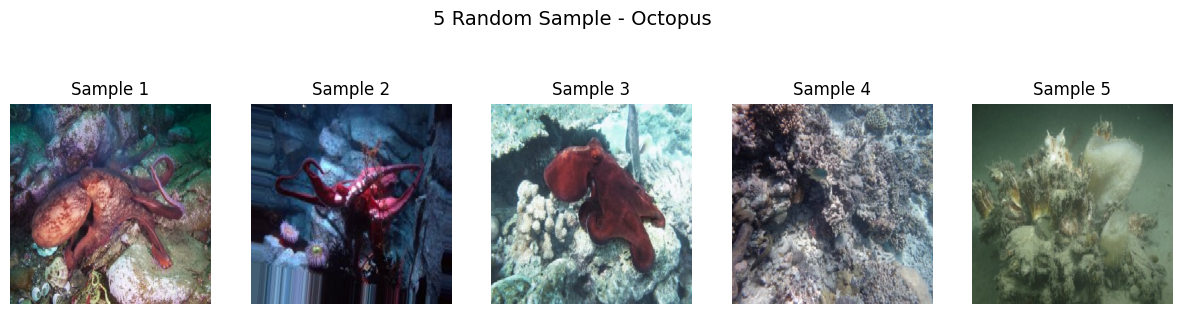

In [14]:
# ambil kelas keempat
fourth_class = CLASS_NAMES[3]
class_path = os.path.join(TRAIN_DIR, fourth_class)

all_files = [
    f for f in os.listdir(class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

all_files = sorted(all_files)

sample_files = random.sample(all_files, SAMPLES_PER_CLASS)

fig, axes = plt.subplots(1, SAMPLES_PER_CLASS, figsize=(15, 4))
fig.suptitle(f"5 Random Sample - {fourth_class}", fontsize=14)

for j, file_name in enumerate(sample_files):
    file_path = os.path.join(class_path, file_name)
    img = load_img(file_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)

    axes[j].imshow(img_array.astype("uint8"))
    axes[j].axis("off")
    axes[j].set_title(f"Sample {j+1}")

plt.show()

Kelas keempat adalah gurita yang memiliki ciri-ciri sebagai berikut:
- Sample berada di lingkungan laut khususnya di antara bebatuan, karang, atau dasar laut yang berpasir
- Memiliki tubuh lunak tanpa tulang eksternal (moluska) dengan kepala yang menyatu dengan tubuh
- Memiliki 8 tentakel
- Warna bervariasi mulai dari cokelat kemerahan hingga cokelat keemasan, dan memiliki kemampuan kamuflase yang baik

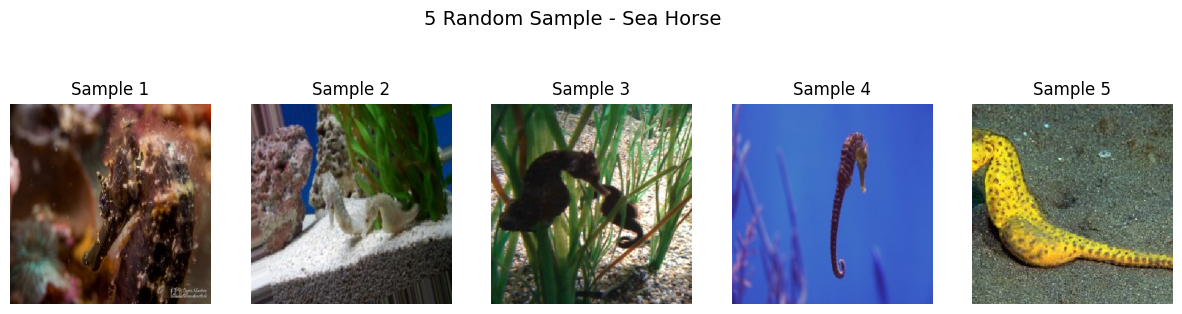

In [15]:
# ambil kelas kelima
fifth_class = CLASS_NAMES[4]
class_path = os.path.join(TRAIN_DIR, fifth_class)

all_files = [
    f for f in os.listdir(class_path)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

all_files = sorted(all_files)

sample_files = random.sample(all_files, SAMPLES_PER_CLASS)

fig, axes = plt.subplots(1, SAMPLES_PER_CLASS, figsize=(15, 4))
fig.suptitle(f"5 Random Sample - {fifth_class}", fontsize=14)

for j, file_name in enumerate(sample_files):
    file_path = os.path.join(class_path, file_name)
    img = load_img(file_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)

    axes[j].imshow(img_array.astype("uint8"))
    axes[j].axis("off")
    axes[j].set_title(f"Sample {j+1}")

plt.show()

Kelas kelima adalah kuda laut yang memiliki ciri-ciri sebagai berikut:
- Memiliki bentuk kepala menyerupai kuda dan tubuh yang ramping memanjang dengan perut besar
- Semua sample berada di lingkungan laut dangkal, berada di antara tanaman air atau karang
- Memiliki ekor yang sering terlihat melingkar namun bisa juga memanjang
- Warna tubuh bervariasi mulai dari cokelat hingga kuning

# Feature Engineering

In [16]:
# menentukan preprocessing
IMAGE_SIZE = (299, 299) # Ukuran yang akan di-resize oleh generator
BATCH_SIZE = 32         # Ukuran batch
SEED = 42

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # data augmentation
    rescale=1./255, # scaling
    rotation_range=15,    # Rotasi 15 derajat
    zoom_range=0.1,       # Zoom 10%
    horizontal_flip=True, # Flip horizontal
)

# Generator untuk Validation & Test Set (Hanya Rescaling)
# Data validasi dan test tidak diaugmentasi, hanya dinormalisasi
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Data Loading Flow from Directory

print("Loading Training Dataset (with Augmentation)...")
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,             # Data training perlu diacak
    seed=SEED
)

print("\nLoading Validation Dataset...")
validation_generator = val_test_datagen.flow_from_directory(
    directory=VALID_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,             # Validation tidak perlu diacak
    seed=SEED
)

print("\nLoading Test Dataset...")
test_generator = val_test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,             # Test tidak perlu diacak
    seed=SEED
)

# Nama kelas diambil dari generator training
CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)

print(f"\nJumlah Kelas Teridentifikasi: {NUM_CLASSES}")
print(f"Nama-nama Kelas: {CLASS_NAMES}")

Loading Training Dataset (with Augmentation)...
Found 1244 images belonging to 5 classes.

Loading Validation Dataset...
Found 250 images belonging to 5 classes.

Loading Test Dataset...
Found 100 images belonging to 5 classes.

Jumlah Kelas Teridentifikasi: 5
Nama-nama Kelas: ['Dolphin', 'Fish', 'Lobster', 'Octopus', 'Sea Horse']


Dilakukan data augmentation untuk meningkatkan performa model dengan penjelasan sebagai berikut:

- Menggunakan ImageDataGenerator dengan parameter rotation_range=15 (karena gambar binatang bawah laut difoto saat berenang sehingga perlu rotasi), zoom_range=0.1 (melakukan zoom agar terfokus ke binatang dan bukan background), dan horizontal_flip=True (lakukan flip agar model bisa mengcapture ke manapun posisi binatang) pada Train Dataset saja. Proses ini bertujuan agar model dilatih pada berbagai variasi kondisi gambar (diputar, diperbesar/diperkecil, dan dibalik), sehingga model mampu mempelajari pola yang lebih umum pada setiap class dan tidak hanya menghafal bentuk gambar tertentu

- Pemisahan data Training, Validation, dan Test dilakukan berdasarkan struktur folder (TRAIN_DIR, VALID_DIR, TEST_DIR). Data Training digunakan untuk melatih model, data Validation digunakan untuk mengevaluasi performa model selama proses training, dan data Test digunakan untuk evaluasi akhir model. Data validation dan test tidak dilakukan augmentasi agar hasil evaluasi mencerminkan performa model pada data asli

- Normalisasi (rescaling) data dilakukan dengan rescale=1./255 pada data Training, Validation, dan Test. Proses ini mengubah nilai pixel dari rentang 0–255 menjadi 0–1 agar perhitungan lebih stabil, mempercepat proses training, serta membantu model belajar dengan lebih efektif

- Proses resizing gambar dilakukan pada seluruh dataset menggunakan parameter target_size=(299, 299). Hal ini diperlukan karena ukuran gambar pada dataset tidak seragam, sedangkan model CNN membutuhkan input dengan ukuran yang konsisten. Selain itu 299 merupakan image size yang optimal untuk model InceptionV3 pada Transfer Learning yang nanti akan dilakukan

- Shuffle data diterapkan pada data training (shuffle=True) untuk mencegah model belajar berdasarkan urutan data, sedangkan data validation dan test tidak dishuffle (shuffle=False) agar hasil evaluasi lebih konsisten

- Penentuan batch size dan class dilakukan dengan batch_size=32 untuk efisiensi penggunaan memori dan stabilitas training. Selain itu, jumlah serta nama kelas diambil secara otomatis dari struktur folder menggunakan class_indices, sehingga proses klasifikasi berjalan sesuai dengan label dataset

# ANN Base Model Training



## Model Definition

In [ ]:
# Clear session

seed = SEED
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Proses clear session digunakan untuk mengosongkan memori dan menghapus sisa konfigurasi model serta cache yang pernah dijalankan sebelumnya. Langkah ini memastikan bahwa setiap proses pelatihan dimulai dalam kondisi bersih, sehingga model membangun pembelajaran sepenuhnya dari awal tanpa dipengaruhi oleh proses training terdahulu

In [ ]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(299, 299,3), kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2)),
Dropout(0.2,seed=seed)
model_aug.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2)),
Dropout(0.2,seed=seed)
model_aug.add(Conv2D(128, (3,3),activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(MaxPooling2D(2, 2)),
Dropout(0.2,seed=seed)
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_aug.add(Dense(5, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Compile
model_aug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,377,925 (306.62 MB)

 Trainable params: 80,377,925 (306.62 MB)

 Non-trainable params: 0 (0.00 B)

Berikut penjelasan detail untuk base model:

- Model menggunakan Sequential API, di mana layer disusun secara berurutan mulai dari input layer, hidden layer, hingga output layer. Sequential API dipilih karena arsitektur model bersifat linear dan relatif sederhana

- CNN digunakan karena baik dalam melakukan ektraksi fitur spasial pada gambar

- Penerapan CNN dilakukan dalam layer bertahap sebagai berikut: pertama covolutional layer (Conv2D) dengan jumlah filter yang meningkat (32, 64, dan 128). Layer ini berfungsi untuk mendeteksi pola, tekstur, dan fitur penting pada gambar dengan cara operasi konvolusi secara bergeser ke samping kemudian ke bawah, kedua max pooling layar dengan ukuran (2, 2) digunakan untuk mereduksi dimensi hasil konvolusi, proses ini menyederhanakan representasi data sehingga mempercepat komputasi dan mengurangi resiko overfitting, ketiga dropout layer, diterapkan setelah proses pooling dengan nilai 0.2, yang berarti sebagian neuron dinonaktifkan secara acak pada setiap batch. Mekanisme ini membantu model agar tidak bergantung pada neuron tertentu saja dan mendorong model belajar pola yang lebih umum

- Flatten Layer digunakan untuk mengubah hasil ekstraksi fitur berbentuk matriks menjadi vektor satu dimensi agar dapat diproses oleh fully connected layer

- Fully Connected (Dense) Layer dengan 512 neuron dan fungsi aktivasi ReLU berperan sebagai hidden layer untuk mempelajari kombinasi fitur yang lebih kompleks. Pada tahap ini juga diterapkan Dropout sebesar 0.5 untuk memperkuat generalisasi model

- Output Layer menggunakan Dense layer dengan 5 neuron dan fungsi aktivasi Softmax, yang sesuai untuk tugas klasifikasi multiclass. Softmax menghasilkan probabilitas untuk setiap kelas sehingga model dapat menentukan kelas dengan probabilitas tertinggi

- Proses kompilasi model dilakukan dengan loss function categorical_crossentropy karena label bersifat one-hot encoded, optimizer Adam untuk mempercepat dan menstabilkan proses pembelajaran, serta metrik accuracy untuk mengevaluasi performa model selama training

## Model Training

In [ ]:
history_seq = model_aug.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            batch_size=32)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.2595 - loss: 43.6310 - val_accuracy: 0.4160 - val_loss: 1.3382
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 849ms/step - accuracy: 0.4141 - loss: 1.3593 - val_accuracy: 0.3920 - val_loss: 1.3968
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 854ms/step - accuracy: 0.4692 - loss: 1.2702 - val_accuracy: 0.3920 - val_loss: 1.5081
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 823ms/step - accuracy: 0.5122 - loss: 1.1644 - val_accuracy: 0.4360 - val_loss: 1.4001
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 853ms/step - accuracy: 0.5565 - loss: 1.1182 - val_accuracy: 0.4040 - val_loss: 1.5195
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 829ms/step - accuracy: 0.5348 - loss: 1.1585 - val_accuracy: 0.4520 - val_loss: 1.4765
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 824ms/step - accuracy: 0.6247 - loss: 0.9773 - val_accuracy: 0.4280 - val_loss: 1.5411
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 832ms/step - accuracy: 0.6078 - loss: 0.9733 - val_accur

Proses pelatihan model dilakukan menggunakan data training dengan jumlah epoch sebanyak 20. Jumlah iterasi ini ditetapkan untuk memberikan kesempatan kepada model dalam meminimalkan nilai loss dan meningkatkan akurasi secara bertahap

Selama proses training, performa model dievaluasi menggunakan data validation melalui parameter validation_data. Dengan cara ini, perkembangan model dapat dipantau pada setiap epoch untuk memastikan kemampuan generalisasi terhadap data yang belum pernah dilihat sebelumnya

Ukuran batch ditetapkan sebesar 32, yang dipilih sebagai nilai tengah antara efisiensi perhitungan dan stabilitas proses pembelajaran selama training

## Model Evaluation

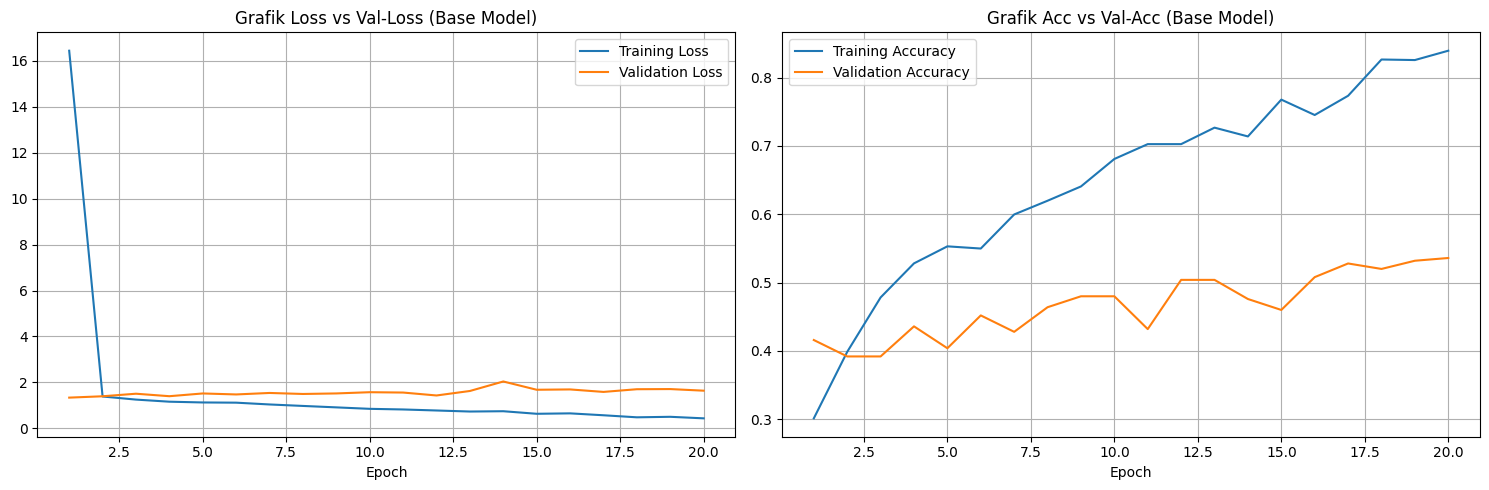

In [ ]:
# Plot training result

history_sequential_df = pd.DataFrame(history_seq.history)

# Buat array epoch: 1 sampai jumlah epoch
epochs = np.arange(1, len(history_sequential_df) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_sequential_df['loss'], label='Training Loss')
plt.plot(epochs, history_sequential_df['val_loss'], label='Validation Loss')
plt.grid(True)
plt.legend()
plt.title('Grafik Loss vs Val-Loss (Base Model)')
plt.xlabel('Epoch')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_sequential_df['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_sequential_df['val_accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.legend()
plt.title('Grafik Acc vs Val-Acc (Base Model)')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

Dapat dilakukan evaluasi pada model menggunakan grafik Loss vs Val-Loss serta grafik Accuracy vs Val-Accuracy

**Loss vs Val-Loss Graph**

- Grafik ini menampilkan perbandingan training loss dan validation loss selama 20 epoch
- Training loss (garis biru) mengalami penurunan konstan hingga mencapai nilai mendekati 0 pada epoch ke-20, yang menunjukkan bahwa model semakin optimal dalam mempelajari data training
- Validation loss (garis oranye) berada pada range 1-2 dan cenderung stabil dengan sedikit kenaikan di beberapa epoch
- Selisih yang cukup besar antara Training loss dan Validation loss mengindikasikan bahwa model mulai menghafal data training dan belum mampu melakukan generalisasi dengan baik pada data validation

**Accuracy vs Val-Accuracy Graph**

- Grafik ini menunjukkan perkembangan akurasi model selama proses training
- Training accuracy (garis biru) meningkat secara konsisten dari sekitar 31% pada epoch awal hingga mencapai sekitar 85% pada epoch terakhir
- Validation accuracy (garis oranye) hanya berada pada range 40% hingga 54%, dengan nilai tertinggi mendekati 55% dan fluktuatif
- Perbedaan akurasi antara data Training dan Validation yang mencapai sekitar 25–30% menunjukkan adanya kecenderungan overfitting

Secara keseluruhan kedua grafik memperlihatkan pola overfitting, di mana performa model pada data Training jauh lebih baik dibandingkan data Validation. Namun model sudah menunjukkan kemampuan belajar yang baik pada data Training dan masih dapat ditingkatkan performanya melalui penyesuaian arsitektur base model, augmentasi tambahan, atau penggunaan transfer learning

Dalam project ini performa model akan ditingkatkan dengan penggunaan transfer learning

In [ ]:
# predict data test
y_pred_prob = model_aug.predict(test_generator)

# pilih class dengan predict probabilitas tertinggi
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# tampilkan hasil dengan predict prob tertinggi
print(classification_report(test_generator.classes, y_pred_class, target_names=np.array(list(train_generator.class_indices.keys()))))

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step
              precision    recall  f1-score   support

     Dolphin       0.74      0.70      0.72        20
        Fish       0.37      0.35      0.36        20
     Lobster       0.65      0.55      0.59        20
     Octopus       0.42      0.50      0.45        20
   Sea Horse       0.33      0.35      0.34        20

    accuracy                           0.49       100
   macro avg       0.50      0.49      0.49       100
weighted avg       0.50      0.49      0.49       100



Dari classification report, didapatkan hasil tiap kelas sebagai berikut:

**Dolphin**
- Precision 74% artinya dari seluruh gambar yang diprediksi sebagai Dolphin, sebanyak 74% diprediksi dengan benar oleh model

- Recall 70% menunjukkan bahwa dari seluruh data Dolphin yang sebenarnya, sekitar 30% masih belum berhasil dikenali sebagai Dolphin.

- F1-Score 72% menandakan bahwa model cukup seimbang dan relatif baik dalam mengklasifikasikan class Dolphin dibandingkan class lainnya

**Fish**
- Precision 37% menunjukkan bahwa prediksi model terhadap class Fish masih lemah, di mana sebagian besar prediksi Fish ternyata berasal dari class lain

- Recall 35% berarti dari seluruh data Fish, hanya 20% yang berhasil dikenali dengan benar oleh model, sementara sekitar 65% masih salah diklasifikasikan

- F1-Score 36% menandakan performa model dalam mengenali class Fish masih rendah dan perlu perbaikan lebih lanjut

**Lobster**
- Precision 65% artinya lebih dari setengah prediksi Lobster benar-benar sesuai dengan label sebenarnya

- Recall 55% menunjukkan bahwa sekitar 35% data Lobster belum berhasil dikenali dengan tepat oleh model

- F1-Score 59% mengindikasikan bahwa kemampuan model dalam mengklasifikasikan Lobster masih tergolong belum baik

**Octopus**
- Precision 42% menunjukkan bahwa prediksi class Octopus masih sering keliru, dengan cukup banyak data dari class lain yang salah diprediksi sebagai Octopus

- Recall 50% berarti hanya sekitar 50% data Octopus yang berhasil dikenali dengan benar oleh model

- F1-Score 45% menandakan bahwa performa model untuk class Octopus masih rendah dan belum stabil

**Sea Horse**
- Precision 33% artinya masih cukup banyak prediksi Sea Horse yang sebenarnya berasal dari class lain

- Recall 35% menunjukkan bahwa kurang dari setengah data Sea Horse mampu dikenali dengan benar oleh model

- F1-Score 34% mengindikasikan bahwa meskipun memiliki tingkat pengenalan, ketepatan prediksi masih sangat perlu ditingkatkan

Secara keseluruhan, model hanya mampu mencapai akurasi sekitar 49% dari total data uji. Nilai macro average dan weighted average F1-Score yang berada di kisaran 49% menunjukkan bahwa performa model masih belum optimal dan belum konsisten di semua class. Model cenderung lebih baik dalam mengenali class Dolphin, namun masih kesulitan membedakan class lain seperti Fish, Lobster, dan Octopus. Hasil ini mengindikasikan bahwa model masih perlu dilakukan perbaikan, baik dari sisi arsitektur, augmentasi data, maupun kualitas dan jumlah dataset agar performa klasifikasi dapat meningkat

# ANN Improvement Model Training with Transfer Learning

Pada tahap model improvement, dilakukan penerapan transfer learning dengan menggunakan InceptionV3. Pemilihan model ini didasarkan pada performa model sebelumnya yang masih menunjukkan keterbatasan dalam membedakan beberapa kelas objek laut, sebagaimana terlihat pada hasil classification report

InceptionV3 dipilih sebagai model transfer learning dengan pertimbangan sebagai berikut:

- Lebih efektif dalam membedakan kelas dengan kemiripan visual tinggi, seperti Fish, Octopus, dan Lobster

- InceptionV3 memiliki Top-1 Accuracy sekitar 78% dan Top-5 Accuracy sekitar 94% pada dataset ImageNet. Performa ini menunjukkan kemampuan generalisasi yang kuat, sehingga diharapkan mampu meningkatkan precision dan recall pada kelas dengan performa rendah dan mengurangi kesalahan klasifikasi antar kelas yang memiliki ciri visual yang mirip

- Size model yang efisien karena package InceptionV3 hanya sekitar 90-95 MB yang jauh lebih kecil dibandingkan VGG16 atau VGG19 yang memiliki size lebih dari 500 MB sehingga proses komputasi bisa lebih efisien tanpa mengorbankan performa model

## Model Definition

In [ ]:
# Clear session

seed = SEED
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Proses clear session kembali digunakan untuk mengosongkan memori dan menghapus sisa konfigurasi model serta cache yang pernah dijalankan sebelumnya

In [ ]:
pretrained_model_iv3 = InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

# freeze most layers
for layer in pretrained_model_iv3.layers[:-40]:
    layer.trainable = False

# unfreeze top layers
for layer in pretrained_model_iv3.layers[-40:]:
    layer.trainable = True

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model InceptionV3 dengan weight pre-trained dari dataset ImageNet digunakan sebagai model pada transfer learning, parameter include_top=False memungkinkan model berfungsi sebagai feature extractor

Sebagian besar layer pada model difreeze untuk mempertahankan fitur dasar yang telah dipelajari, sementara 40 layer terakhir tidak difreeze untuk dilakukan proses tuning. Strategi ini bertujuan agar model dapat menyesuaikan fitur pada top layer dengan karakteristik spesifik dataset objek laut.

Unfreeze seluruh layer tidak dilakukan karena dapat meningkatkan risiko overfitting, memperbesar kebutuhan komputasi, serta berpotensi mengganggu kestabilan pre-trained weight, terutama pada kondisi jumlah data train yang terbatas. Sehingga diharapkan mampu meningkatkan performa klasifikasi secara efektif dengan tetap menjaga efisiensi proses train

In [ ]:
model_aug_iv3 = Sequential()

# Pretrained backbone
model_aug_iv3.add(pretrained_model_iv3)

# Pooling
model_aug_iv3.add(GlobalAveragePooling2D())

# Classification head
model_aug_iv3.add(BatchNormalization())

model_aug_iv3.add(Dense(
    256,
    activation="relu",
    kernel_initializer=tf.keras.initializers.HeNormal(seed)
))

model_aug_iv3.add(Dropout(0.5))

# Output layer (multiclass)
model_aug_iv3.add(Dense(NUM_CLASSES, activation="softmax"))

In [ ]:
optimizer = Adam(learning_rate=1e-4)

model_aug_iv3.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Berikut penjelasan untuk improved model:

- Sama seperti base model, improved model juga menggunakan Sequential API, di mana layer disusun secara berurutan mulai dari pre-trained hingga output layer. Pendekatan ini dipilih karena arsitektur model bersifat linear dan relatif sederhana untuk diimplementasikan.

- InceptionV3 dengan bobot pre-trained ImageNet digunakan sebagai base model (CNN) yang berfungsi sebagai feature extractor. Model ini mampu mengekstraksi fitur gambar yang kompleks

- GlobalAveragePooling2D digunakan untuk mereduksi dimensi hasil ekstraksi fitur. Layer ini menggantikan flatten layer konvensional yang digunakan pada base model sehingga jumlah parameter berkurang, komputasi lebih efisien, dan risiko overfitting dapat diminimalkan

- Batch Normalization diterapkan pada classification head untuk menstabilkan proses train

- Dense Layer dengan 256 neuron dan fungsi aktivasi ReLU digunakan sebagai hidden layer untuk mempelajari kombinasi fitur yang lebih kompleks. Inisialisasi bobot menggunakan He Normal diterapkan untuk menyesuaikan karakteristik aktivasi ReLU

- Dropout sebesar 0.5 ditambahkan setelah Dense layer untuk mengurangi ketergantungan model pada neuron tertentu dan meningkatkan kemampuan generalisasi gambar

- Output Layer menggunakan Dense layer dengan jumlah neuron sesuai jumlah kelas dan fungsi aktivasi Softmax, yang sesuai untuk tugas klasifikasi multiclass karena menghasilkan probabilitas untuk setiap kelas

- Proses kompilasi model menggunakan optimizer Adam dengan learning rate 1e-4 untuk menjaga stabilitas fine-tuning, loss function categorical_crossentropy karena label bersifat one-hot encoded, serta metrik accuracy untuk mengevaluasi performa model selama proses training

In [ ]:
train_datagen_iv3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen_iv3 = ImageDataGenerator(preprocessing_function=preprocess_input)

Proses augmentation pada data train improved model dibuat sama (rotation_range = 15, zoom_range = 0.1, horizontal_flip=True) dengan yang dilakukan pada data train base model, dengan perbedaan hanya pada rescale yang digantikan dengan preprocessing_function

Rescale tidak dilakukan karena telah dilakukan preprocessing_function bawaan library InceptionV3, kode preprocess_function ini melakukan instruksi mengconvert nilai pixel dari [0, 225] ke [-1, 1], serupa dengan yang dilakukan oleh rescale

Preprocessing ini juga diperlukan karena InceptionV3 dilatih di ImageNet menggunakan proses normalisasi ini, sehingga performa yang dihasilkan akan lebih maksimal dibandingkan dengan menambahkan kode rescale saat augmentation datagen

In [ ]:
train_generator_iv3 = train_datagen_iv3.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

validation_generator_iv3 = val_test_datagen_iv3.flow_from_directory(
    directory=VALID_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_iv3 = val_test_datagen_iv3.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 1244 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.3)
]

Kemudian untuk semakin mengoptimalkan performa model, ditentukan parameter callbacks dengan penjelasan sebagai berikut:

- EarlyStopping diterapkan untuk menghentikan proses training secara otomatis ketika nilai validation loss (val_loss) tidak mengalami perbaikan selama 5 epoch berturut-turut. Ini bertujuan untuk mencegah terjadinya overfitting. Parameter restore_best_weights=True digunakan agar model kembali menggunakan bobot terbaik yang diperoleh selama proses training

- ReduceLROnPlateau digunakan untuk menurunkan nilai learning rate ketika validation loss tidak mengalami penurunan selama 3 epoch berturut-turut. Dengan faktor pengurangan sebesar 0.3, learning rate menjadi lebih kecil sehingga proses pembelajaran dapat berlangsung lebih halus dan stabil

## Model Training

In [ ]:
history_fine = model_aug_iv3.fit(
    train_generator_iv3,
    validation_data=validation_generator_iv3,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6032 - loss: 1.1967 - val_accuracy: 0.7840 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 856ms/step - accuracy: 0.9247 - loss: 0.2179 - val_accuracy: 0.7960 - val_loss: 0.5906 - learning_rate: 1.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 869ms/step - accuracy: 0.9353 - loss: 0.1875 - val_accuracy: 0.8360 - val_loss: 0.4779 - learning_rate: 1.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 856ms/step - accuracy: 0.9588 - loss: 0.1013 - val_accuracy: 0.8720 - val_loss: 0.4314 - learning_rate: 1.0000e-04
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 872ms/step - accuracy: 0.9755 - loss: 0.0741 - val_accuracy: 0.8840 - val_loss: 0.3931 - learning_rate: 1.0000e-04
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 856ms/step - accuracy: 0.9733 - loss: 0.0714 - val_accuracy: 0.8720 - val_loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 871ms/step - accura

## Model Evaluation

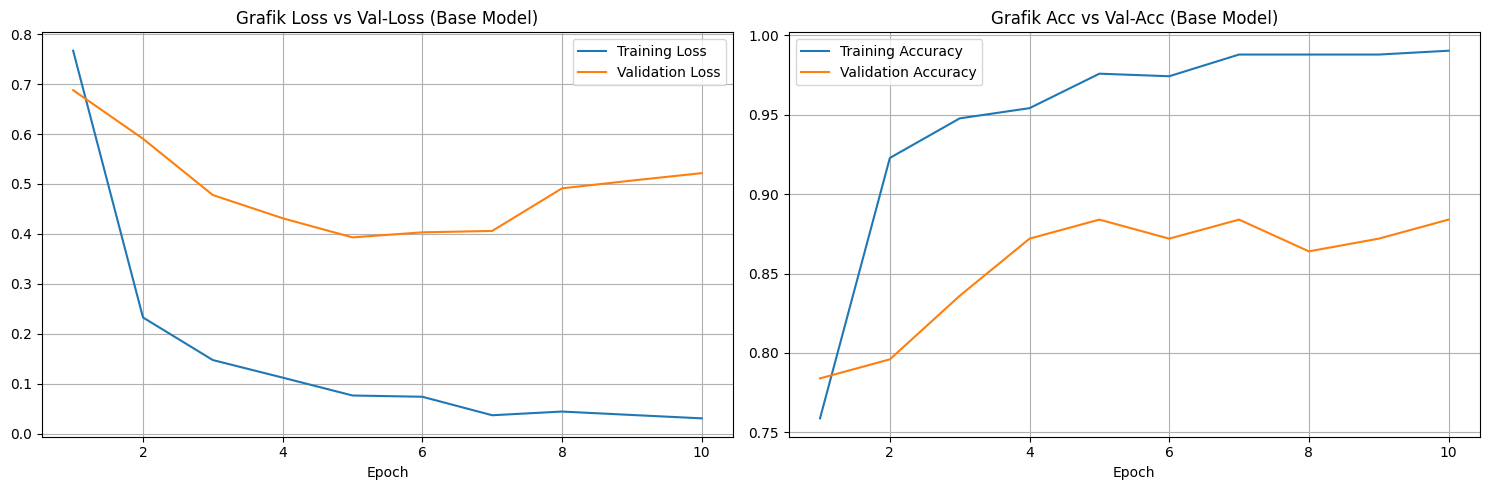

In [ ]:
# Plot training result

history_fine_df = pd.DataFrame(history_fine.history)

# Buat array epoch: 1 sampai jumlah epoch
epochs = np.arange(1, len(history_fine_df) + 1)

plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_fine_df['loss'], label='Training Loss')
plt.plot(epochs, history_fine_df['val_loss'], label='Validation Loss')
plt.grid(True)
plt.legend()
plt.title('Grafik Loss vs Val-Loss (Base Model)')
plt.xlabel('Epoch')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_fine_df['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_fine_df['val_accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.legend()
plt.title('Grafik Acc vs Val-Acc (Base Model)')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

Dapat dilakukan evaluasi pada model menggunakan grafik Loss vs Val-Loss serta grafik Accuracy vs Val-Accuracy

**Loss vs Val-Loss Graph**

- Training loss (garis biru) mengalami penurunan yang sangat signifikan dari nilai awal sekitar 0.75 hingga mendekati 0 pada epoch terakhir. Pola ini menunjukkan bahwa model sangat baik dalam mempelajari data training

- Validation loss (garis oranye) pada awal training ikut mengalami penurunan, namun setelah beberapa epoch cenderung stagnan dan meningkat kembali, berada pada kisaran 0.68–0.52

- Perbedaan yang cukup besar (0.55) antara training loss dan validation loss mengindikasikan bahwa model sangat menghafal data training dan tidak mampu mempertahankan performa yang sama pada data validasi

- Pola ini merupakan indikasi terjadinya overfitting, di mana model terlalu menyesuaikan diri dengan data training

**Accuracy vs Val-Accuracy Graph**

- Training accuracy (garis biru) meningkat secara konsisten dari sekitar 76% pada epoch awal hingga mencapai hampir 98% pada epoch terakhir, yang menandakan bahwa model memiliki kemampuan belajar yang sangat baik pada data training

- Validation accuracy (garis oranye) meningkat di awal training hingga mencapai nilai tertinggi sekitar 88%, namun setelah itu cenderung berfluktuasi dan tidak mengalami peningkatan signifikan

- Selisih akurasi yang cukup besar (10%) antara data training dan validation menunjukkan bahwa model memiliki performa yang jauh lebih baik pada data training dibandingkan data validation

- Perbedaan ini menguatkan indikasi adanya overfitting, meskipun model telah mencapai akurasi training yang sangat tinggi

Secara keseluruhan, kedua grafik menunjukkan pola overfitting, di mana performa model pada data training meningkat secara signifikan, namun tidak diikuti oleh peningkatan yang sebanding pada data validation. Hal ini menunjukkan bahwa meskipun model memiliki kemampuan belajar yang baik, kemampuan generalisasi terhadap data baru masih terbatas

Oleh karena itu, pada tahap selanjutnya performa model perlu ditingkatkan melalui strategi seperti percobaan transfer learning dengan model lain, fine-tuning layer tertentu, penyesuaian arsitektur model, serta regularisasi tambahan, agar model dapat menghasilkan performa yang lebih seimbang antara data training dan validation

In [ ]:
# predict data test
y_pred_prob = model_aug_iv3.predict(test_generator_iv3)

# pilih class dengan predict probabilitas tertinggi
y_pred_class = np.argmax(y_pred_prob, axis=-1)

# tampilkan hasil dengan predict prob tertinggi
print(classification_report(test_generator_iv3.classes, y_pred_class, target_names=np.array(list(train_generator_iv3.class_indices.keys()))))

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
              precision    recall  f1-score   support

     Dolphin       1.00      0.95      0.97        20
        Fish       0.87      0.65      0.74        20
     Lobster       1.00      0.80      0.89        20
     Octopus       0.80      1.00      0.89        20
   Sea Horse       0.76      0.95      0.84        20

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.89      0.87      0.87       100



Dari classification report, diperoleh hasil evaluasi performa model pada masing-masing kelas sebagai berikut:

**Dolphin**
- Precision 100% menunjukkan bahwa seluruh gambar yang diprediksi sebagai Dolphin benar-benar berasal dari kelas Dolphin, sehingga tidak terdapat false positive pada kelas ini.

- Recall 95% berarti dari seluruh data Dolphin yang sebenarnya, hanya sekitar 5% yang belum berhasil dikenali oleh model.

- F1-Score 97% menandakan bahwa model memiliki performa yang sangat baik dan seimbang dalam mengklasifikasikan kelas Dolphin.

**Fish**
- Precision 87% menunjukkan bahwa identifikasi fish cukup baik

- Recall 65% berarti masih kesulitan mengidentifikasi fish

- F1-Score 74% menandakan bahwa model cukup kesulitan dalam identifikasi kelas fish

**Lobster**
- Precision 100% menandakan bahwa seluruh prediksi Lobster dilakukan dengan sangat tepat tanpa adanya kesalahan prediksi dari kelas lain.

- Recall 80% menunjukkan bahwa sekitar 20% data Lobster belum berhasil dikenali oleh model.

- F1-Score 89% mengindikasikan bahwa model memiliki kemampuan klasifikasi yang sangat baik pada kelas Lobster.

**Octopus**
- Precision 80% menunjukkan bahwa sebagian besar prediksi Octopus sudah benar, meskipun masih terdapat sedikit kesalahan prediksi dari kelas lain.

- Recall 100% berarti seluruh data Octopus berhasil dikenali dengan benar oleh model.

- F1-Score 89% menandakan bahwa model mampu mengenali kelas Octopus dengan tingkat akurasi dan stabilitas yang tinggi.

**Sea Horse**
- Precision 76% menunjukkan bahwa masih terdapat beberapa prediksi Sea Horse yang berasal dari kelas lain.

- Recall 95% berarti hampir seluruh data Sea Horse pada data uji berhasil dikenali oleh model

- F1-Score 84% mengindikasikan bahwa meskipun tingkat pengenalan sangat baik, ketepatan prediksi masih dapat ditingkatkan lebih lanjut

Secara keseluruhan, model berhasil mencapai akurasi sebesar 87% pada data uji. Nilai macro average dan weighted average F1-Score yang sama-sama berada pada kisaran 87% menunjukkan bahwa performa model sudah baik dan relatif konsisten pada seluruh kelas

Jika dibandingkan dengan base model yang hanya mencapai akurasi sekitar 49%, di mana terdapat peningkatan akurasi hampir 40%, penerapan transfer learning menggunakan InceptionV3 terbukti memberikan peningkatan performa yang signifikan, terutama dalam membedakan kelas-kelas dengan kemiripan visual tinggi seperti Fish, Lobster, dan Octopus. Hasil ini menunjukkan bahwa model yang dikembangkan telah memiliki kemampuan generalisasi yang jauh lebih baik dan layak digunakan sebagai model akhir dalam project ini

Hanya saja perlu beberapa adjustment lebih lanjut untuk meminimalisir over fitting yang terjadi

# Model Saving

Dari Model Evaluation didapat bahwa hasil terbaik didapat dari model dengan transfer learning InceptionV3 sehingga akan disave dan digunakan

In [ ]:
# save model terbaik hasil transfer learning InceptionV3

model_aug_iv3.save('marine_classification.keras')

# Kesimpulan

**Data dan Model**
- Project ini bertujuan untuk membangun model klasifikasi biota laut (Dolphin, Fish, Lobster, Octopus, dan Sea Horse) dari data gambar bawah air untuk mendukung pemantauan keanekaragaman hayati laut (marine biodiversity). Pada project ini didapat model baseline Convolutional Neural Network (CNN) sederhana yang hanya mampu mencapai akurasi sebesar 49%, menunjukkan kesulitan model dalam membedakan kelas-kelas dengan kemiripan visual yang tinggi

- Dilakukan augmentasi data (rotasi, zoom, horizontal flip) hanya pada data train dan normalisasi (0-1) pada seluruh data. Semua gambar diseragamkan ukurannya menjadi (299, 299) untuk menyesuaikan dengan arsitektur model yang digunakan

- Arsitektur Transfer Learning menggunakan InceptionV3 dengan bobot pre-trained ImageNet dipilih untuk meningkatkan performa model. Model diimplementasikan dengan strategi fine-tuning pada 40 layer teratas untuk mengadaptasi fitur pada dataset biota laut

- Penerapan Transfer Learning terbukti sangat signifikan, meningkatkan akurasi model pada data uji dari 49% menjadi 87%, atau peningkatan hampir 40%

- Metric Evaluasi: Model menunjukkan kemampuan generalisasi yang jauh lebih baik dengan nilai F1-Score (Macro Average) sebesar 0.87 dan telah berhasil membedakan kelas-kelas yang sulit seperti Fish, Lobster, dan Octopus secara lebih akurat.

- Meskipun peningkatan performa sangat drastis, hasil analisis menunjukkan adanya potensi overfitting yang ringan, di mana akurasi data train sangat tinggi 99% dibandingkan akurasi validation 87%, pada tahap selanjutnya performa model perlu ditingkatkan melalui strategi seperti percobaan transfer learning dengan model lain, penambahan image pada dataset, fine-tuning layer tertentu, penyesuaian arsitektur model, serta regularisasi tambahan, sehingga dapat menghasilkan model good fit

**Use Case Recommendation**
- Model klasifikasi InceptionV3 dengan akurasi 87% dan F1-Score (Macro Average) 0.87 dapat diintegrasikan ke dalam sistem analisis gambar atau video bawah air. Model ini akan secara otomatis menggantikan proses identifikasi manual yang lambat dan rentan kesalahan

- Keandalan model yang tinggi pada identifikasi spesies tertentu (misalnya, Dolphin dengan F1-Score 0.97 dan Lobster/Octopus dengan F1-Score 0.89) harus dimanfaatkan untuk menyediakan data keanekaragaman hayati yang akurat dan reliable

- Untuk mengatasi indikasi overfitting yang terjadi, perlu untuk menambahkan lebih banyak variasi data, terutama untuk kelas dengan recall yang relatif lebih rendah (seperti 'Fish'), untuk memperkuat kemampuan model selain itu bisa juga

- Bisa juga integrasikan model ke dalam pipeline pemrosesan data bervolume tinggi, baik untuk analisis video real-time dari ROV (Remotely Operated Vehicle) atau pemrosesan batch dari data survei harian, guna menghasilkan laporan spesies yang cepat dan komprehensif